In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os 
import zipfile
from tqdm import tqdm
from glob import glob
from shutil import copy, move
from sklearn.metrics import confusion_matrix

## Data Preparation

In [83]:
zipfile_dir = '../input/dogs-vs-cats/train.zip'
train_dir = zipfile.ZipFile(zipfile_dir, 'r')
train_dir.extractall()

zipfile_dir = '../input/dogs-vs-cats/test1.zip'
test_dir = zipfile.ZipFile(zipfile_dir, 'r')
test_dir.extractall()

In [84]:
TRAIN_DIR = './train'
TEST_DIR = './test1'

train_set = os.listdir(TRAIN_DIR)
test_set = os.listdir(TEST_DIR)

# print('#train images: %s'%len(train_set))
# print('#test images: %s'%len(test_set))
# print(train_set[:5])
# print(test_set[:5])

In [85]:
dog_train_dir = './training/dog'
dog_val_dir = './validation/dog'
cat_train_dir = './training/cat'
cat_val_dir = './validation/cat'

file_dirs = [dog_train_dir, dog_val_dir, cat_train_dir, cat_val_dir]

for dir in file_dirs:
    os.makedirs(dir,exist_ok = True)

In [86]:
all_dogs = glob('./train/dog*jpg')
all_cats = glob('./train/cat*jpg')

print(len(all_dogs))
print(len(all_cats))

12500
12500


In [87]:
from sklearn.model_selection import train_test_split

dogs_train, dogs_test = train_test_split(all_dogs, test_size=0.1, shuffle=True,random_state = 100)
cats_train, cats_test = train_test_split(all_cats, test_size=0.1, shuffle=True,random_state = 100)

In [88]:
for name in tqdm(dogs_train):
  copy(name , os.path.join(dog_train_dir , name.split('/')[-1]))
for name in tqdm(cats_train):
  copy(name , os.path.join(cat_train_dir , name.split('/')[-1]))
  
for name in tqdm(dogs_test):
  copy(name , os.path.join(dog_val_dir , name.split('/')[-1]))
for name in tqdm(cats_test):
  copy(name , os.path.join(cat_val_dir , name.split('/')[-1]))

100%|██████████| 1250/1250 [00:00<00:00, 5288.57it/s]


## Data Preprocessing

In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = './training'
train_datagen = ImageDataGenerator(rescale=1 / 255)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=64,
    class_mode='binary',
    target_size=(150, 150)
)

VALIDATION_DIR = './validation'
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size = 64,
    class_mode = 'binary',
    target_size = (150, 150)
)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Model Creation

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout

model = Sequential()
model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu',kernel_initializer='he_normal',input_shape=(150, 150, 3)))
model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu',kernel_initializer='he_normal'))
model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu',kernel_initializer='he_normal'))
model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, (3,3), strides=(1,1), padding='same', activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Conv2D(512, (3,3), strides=(1,1), padding='same', activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Conv2D(512, (3,3), strides=(1,1), padding='same', activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=1, activation='sigmoid'))

In [91]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 75, 75, 128)       147584    
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 75, 75, 128)      

In [92]:
check_point_path = './best.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = check_point_path,
    monitor = 'val_accuracy',
    save_weights_only=False,
    save_best_only=True,
    verbose=1
)

In [93]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.0005,decay=1e-5),
             loss = 'binary_crossentropy',
             metrics = ['acc'])

In [94]:
print('Num Params : ',model.count_params())
model_history = model.fit(
    train_generator,
    epochs=10,
    verbose=1,
    callbacks = [model_checkpoint],
    validation_data=validation_generator
)

Num Params :  52351425
352/352 [==============================] - 99s 277ms/step - loss: 4.4094 - acc: 0.5088 - val_loss: 0.6951 - val_acc: 0.5000


## Model Evaluation

Plotting Loss and Accuracy

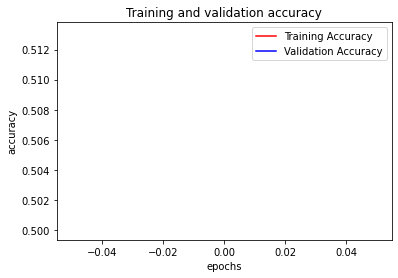

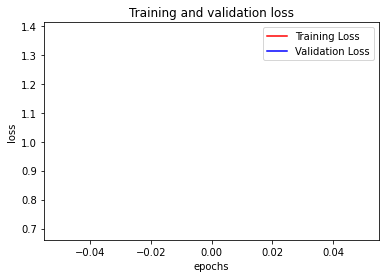

In [95]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=model_history.history['acc']
val_acc=model_history.history['val_acc']
loss=model_history.history['loss']
val_loss=model_history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(["Training Loss","Validation Loss"])
plt.show()

# Desired output. Charts with training and validation metrics. 

In [96]:
test_file = os.listdir("./test1")
test_df = pd.DataFrame({
    'filename': test_file
})
test_df

,filename
0,6813.jpg
1,12014.jpg
2,1497.jpg
3,1446.jpg
4,3148.jpg
...,...
12495,687.jpg
12496,9228.jpg
12497,10611.jpg
12498,2638.jpg


In [97]:
TESTING_DIR = './test1'
test_generator = train_datagen.flow_from_dataframe(
    test_df,
    directory = TESTING_DIR,
    x_col='filename',
    y_col=None,
    batch_size=64,
    target_size=(150, 150),
    shuffle = False,
    class_mode = None
)

Found 12500 validated image filenames.


In [98]:
test_generator.reset()
y_pred = model.predict(test_generator)

To see the class mapping of dogs and cats, we have to see class_indices from training dataset

In [99]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

Let's make labels

In [100]:
y_pred_classification = np.where(y_pred > 0.5, 1, 0)
y_pred_classification

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

Seeing some results

In [101]:
y_true = []

for file in os.listdir("./test1") :
    if file.startswith("Dog"):
        y_true.append(1)
    else :
        y_true.append(0)


        
print("Confusion matrix :")
print(confusion_matrix(y_true, y_pred_classification))

# 


print("Test generator")

test_generator.reset()
test_images = test_generator[0][:9]

fig, ax = plt.subplots(3,3)
fig.set_size_inches(10,10)
for i, img in enumerate(test_images):
    ax[i//3][i%3].imshow(img)
    if y_pred_classification[i]==1:
        label = 'Dog'
    else:
        label = 'Cat'
    ax[i//3][i%3].set_title(label)

Confusion matrix :


ValueError: Found input variables with inconsistent numbers of samples: [25000, 12500]

Visualizing first 9 filters

In [ ]:
model.layers

In [ ]:
first_conv = model.layers[0]
output_layer1 = first_conv(test_images)[4]

print(output_layer1.shape)
fig, ax = plt.subplots(3,3)
fig.set_size_inches(10,10)
for i in range(9):
  ax[i//3][i%3].imshow(output_layer1[:,:,i])

## Submition

In [ ]:
submission = pd.read_csv('../input/dogs-vs-cats/sampleSubmission.csv')
submission['label'] = y_pred_classification
submission

In [ ]:
submission.to_csv('submission.csv',index='False')